In [1]:
%pylab inline
import mne
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Opening raw data file /Users/dkristensen/Documents/Masters Program/IFT 6269 - Probabilistic Graphical Models/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.


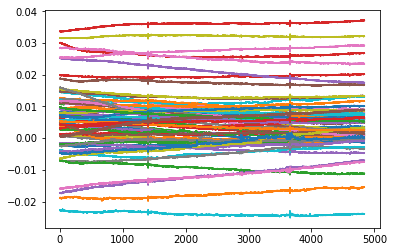

In [85]:
filename = "P01-raw.fif"
raw = mne.io.read_raw_fif(filename)

sfreq = raw.info['sfreq']

block_data,times = raw[:-2,:]
block_data = block_data.T

plot(times,block_data)
show()

In [125]:
# Number of iterations in Kalman Filter
N_iter = int(60*sfreq)
start_second = 50
end_second = 55


In [126]:
def normal_prob(x,mu,sigma):
    front = 1/(2*np.pi*np.sqrt(np.linalg.det(sigma)))
    exponent = np.matmul((x-mu),np.matmul(np.linalg.inv(sigma),(x-mu)).T)
    return front * math.e**(-1/2 * exponent)[0]

class KalmanFilter:
    starting_value = 0.001
    default_state_diagonal = 0.05
    def __init__(self,n_features,noise_sensitivity):
        self.features = n_features
        
        self.state_estimate = (np.ones(self.features)*KalmanFilter.starting_value).reshape(self.features,1)
        self.state_cov = np.diag([KalmanFilter.default_state_diagonal]*self.features)

        self.transition_matrix = (np.eye(self.features)+(np.ones(shape=(self.features,self.features))-np.eye(self.features))*0.000001)
        
        self.noise_cov = np.eye(self.features)/(sfreq*noise_sensitivity)

        self.obs_model = np.eye(self.features)
        self.obs_cov = np.eye(self.features)
        
    def predict(self):
        state_estimate = np.matmul(self.transition_matrix, self.state_estimate)
        state_cov = np.matmul(self.transition_matrix, np.matmul(self.state_cov, self.transition_matrix.T)) + self.noise_cov
        return state_estimate,state_cov 
    
    def update(self,data):
        innovation_prefit = data - np.matmul(self.obs_model,self.state_estimate) 
        innovation_covariance = self.obs_cov + np.matmul(self.obs_model,np.matmul(self.state_cov,self.obs_model.T))

        Kalman_gain = np.matmul(self.state_cov,np.matmul(self.obs_model.T,np.linalg.inv(innovation_covariance)))
        
        updated_state = self.state_estimate+np.matmul(Kalman_gain,innovation_prefit)
        state_cov_helper = np.identity(Kalman_gain.shape[0])-np.matmul(Kalman_gain,self.obs_model)
        
        updated_state_cov = np.matmul(state_cov_helper,np.matmul(self.state_cov,state_cov_helper.T)) + np.matmul(Kalman_gain,np.matmul(self.obs_cov,Kalman_gain.T))
        innovation_postfit = data - np.matmul(self.obs_model,updated_state)
        
        return updated_state,updated_state_cov,innovation_prefit,innovation_postfit

    
    def train(self,data):
        self.state_estimate = data[0].reshape(self.features,1)
        for i in range(data.shape[0]):
            if(i%(int(data.shape[0]/10)) == 0):
                print(i/data.shape[0])
            self.state_estimate,self.state_cov = self.predict()
            self.state_estimate,self.state_cov, prefit, postfit = self.update(data[i].reshape(self.features,1))
        return
    
    def fit(self,data):
        self.state_estimate = data[0].reshape(self.features,1)
        estimates = np.zeros_like(data)
        for i in range(data.shape[0]):
            if(i%(int(data.shape[0]/10)) == 0):
                print(i/data.shape[0])
            self.state_estimate,self.state_cov = self.predict()
            self.state_estimate,self.state_cov, prefit, postfit = self.update(data[i].reshape(self.features,1))
            estimates[i] = self.state_estimate.reshape(self.features)
        return estimates
    
    def clean(self,data):
        cleaned_states = np.zeros_like(data)
        self.state_estimate = data[0].reshape(self.features,1)
        for i in range(data.shape[0]):
            if(i%(int(data.shape[0]/10)) == 0):
                print(i/data.shape[0])
#             self.state_estimate = data[i]
            self.state_estimate,self.state_cov = self.predict()
            cleaned_states[i] = self.state_estimate.reshape(self.features)
            self.state_estimate = self.state_estimate.reshape(self.features,1)
        return cleaned_states

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


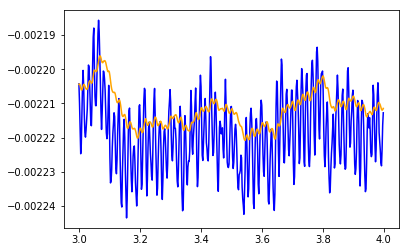

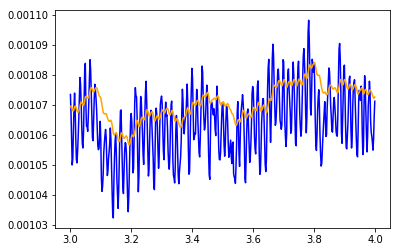

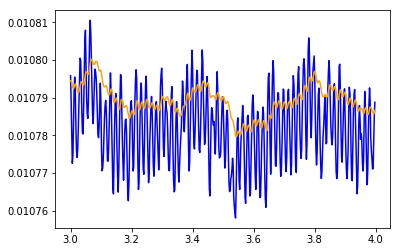

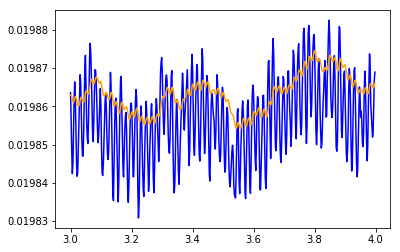

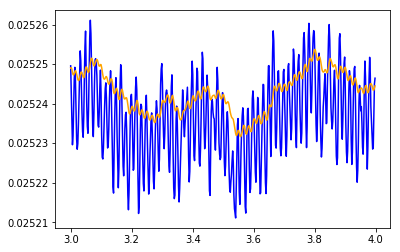

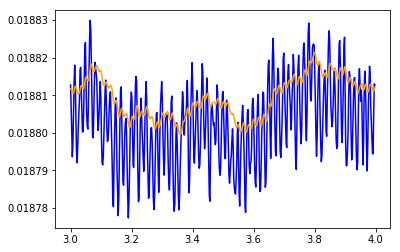

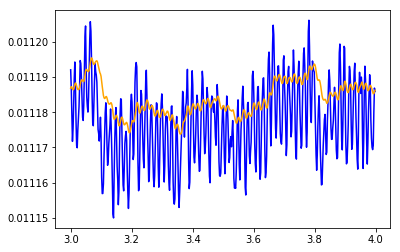

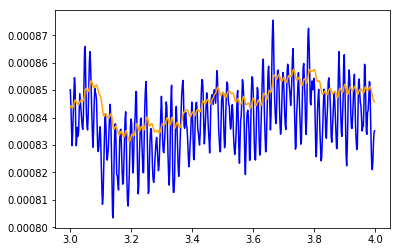

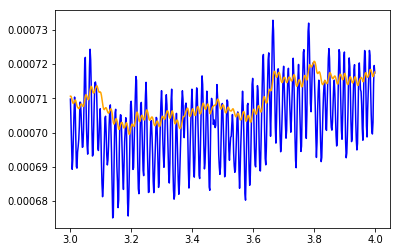

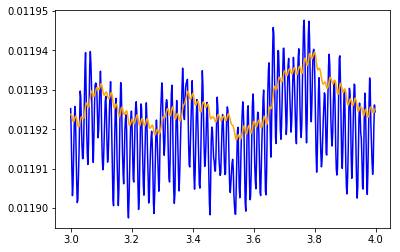

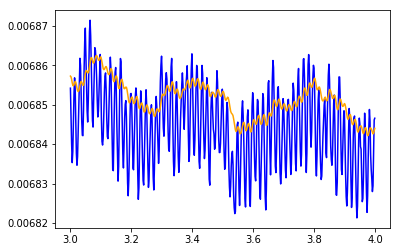

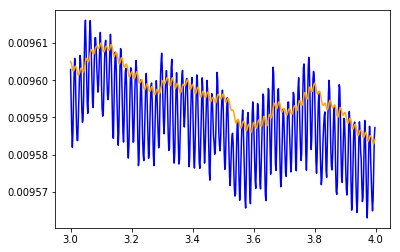

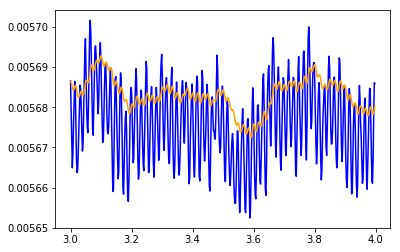

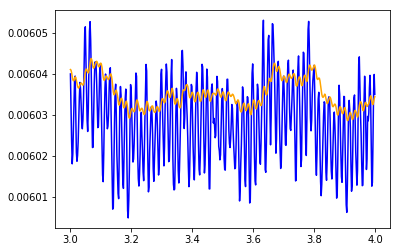

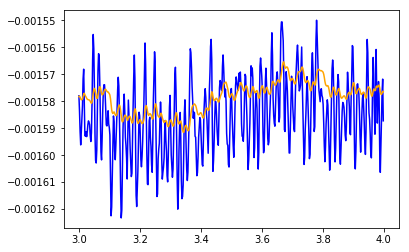

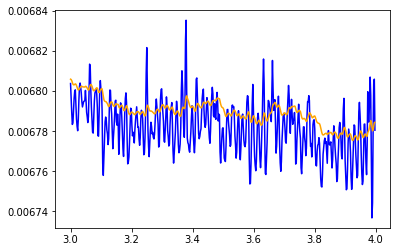

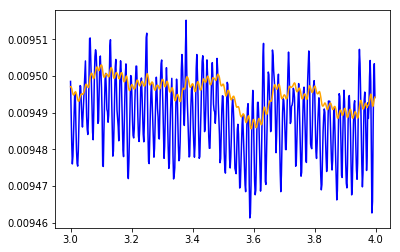

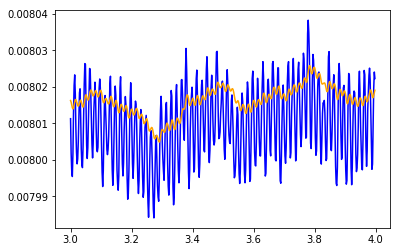

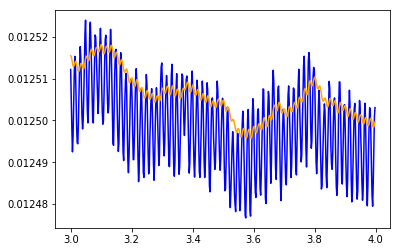

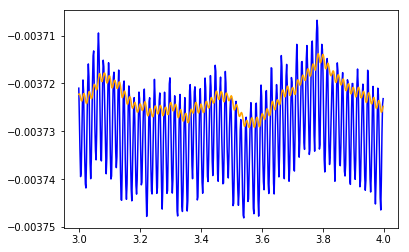

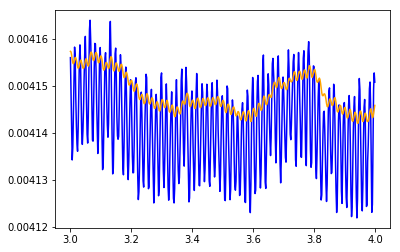

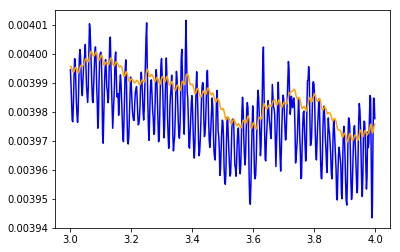

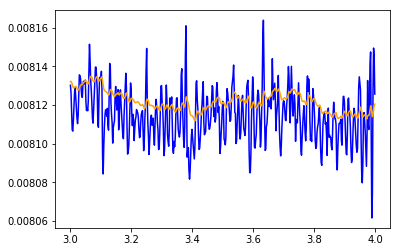

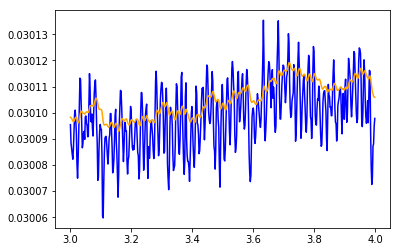

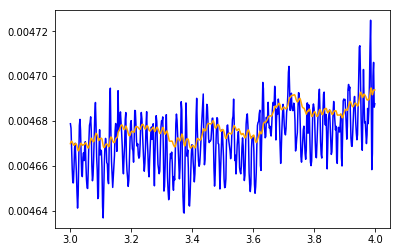

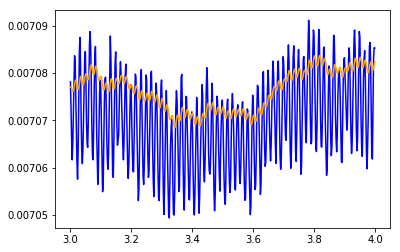

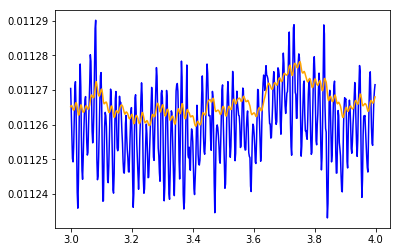

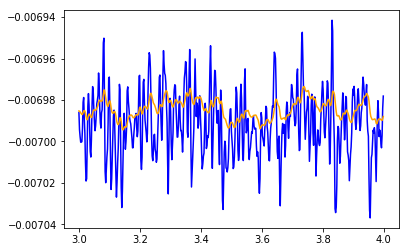

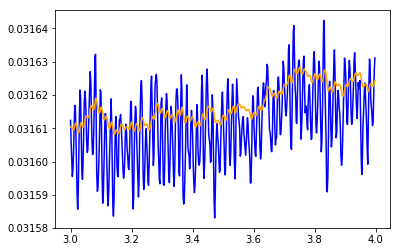

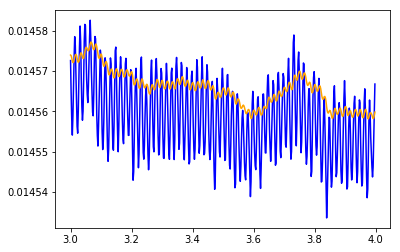

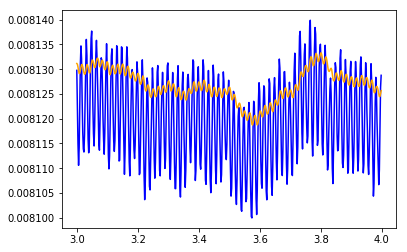

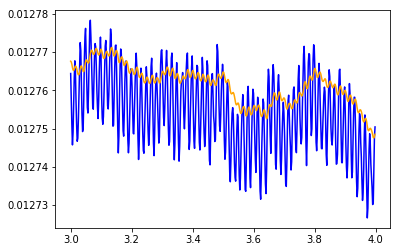

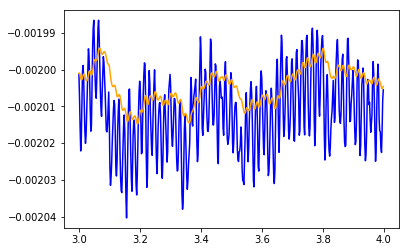

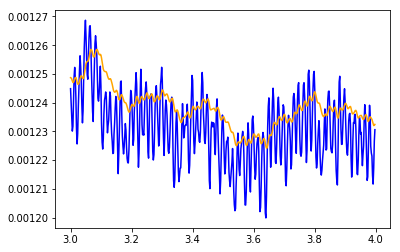

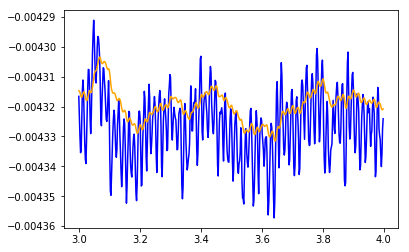

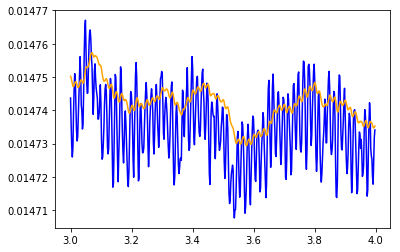

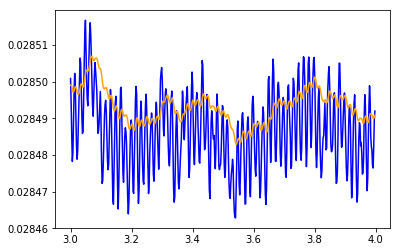

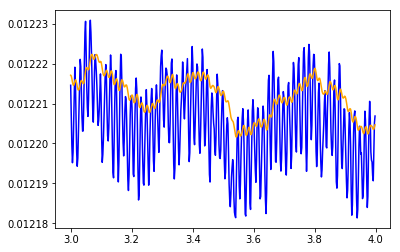

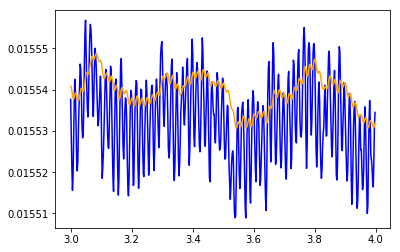

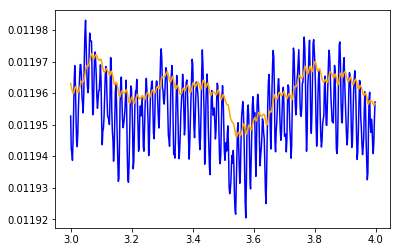

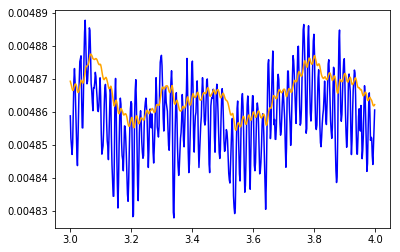

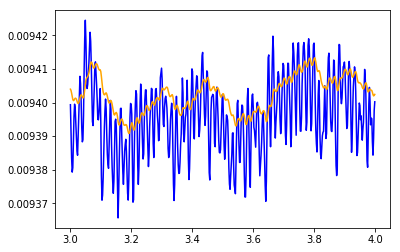

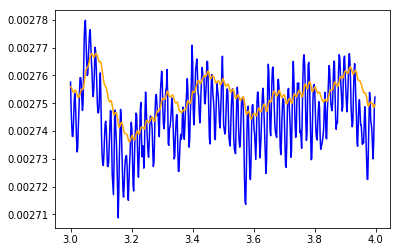

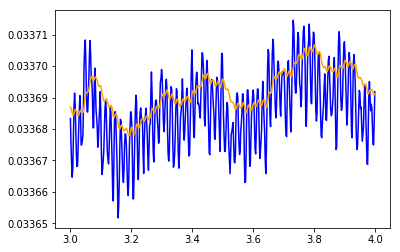

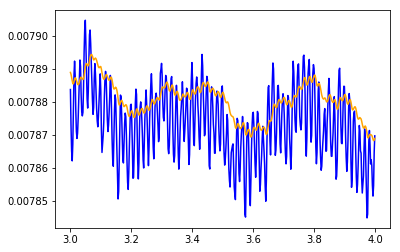

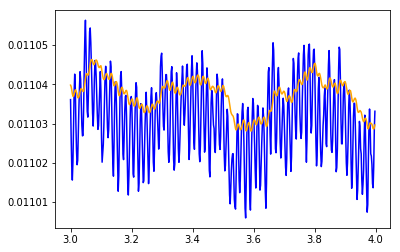

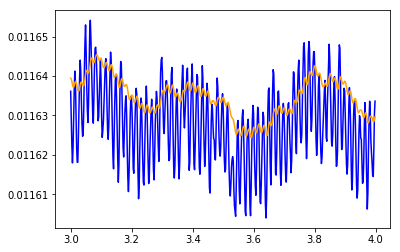

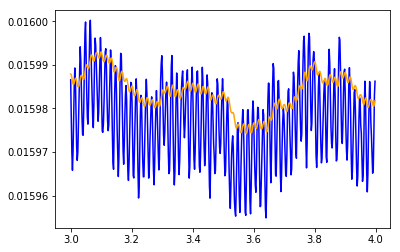

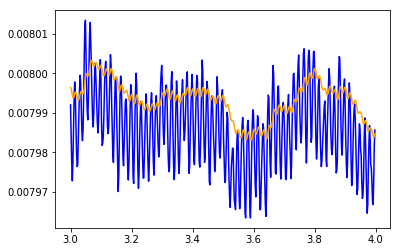

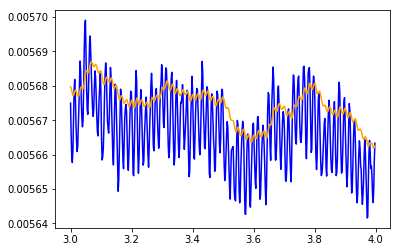

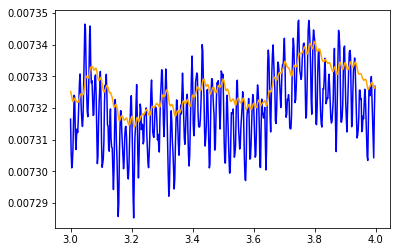

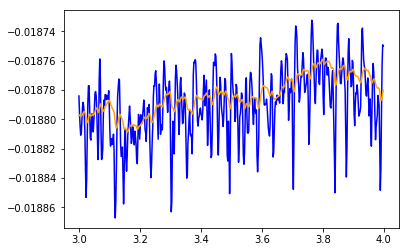

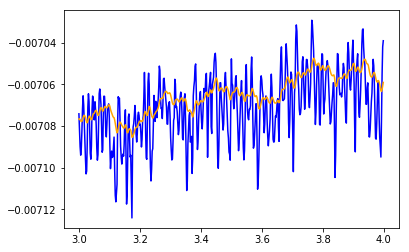

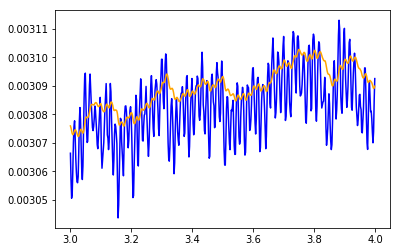

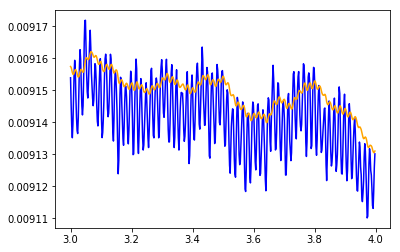

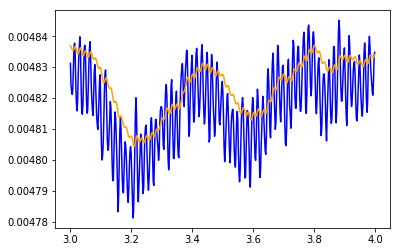

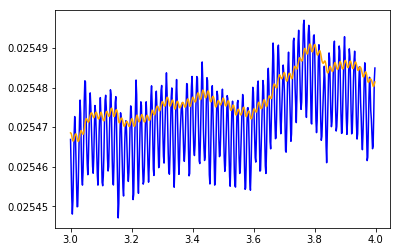

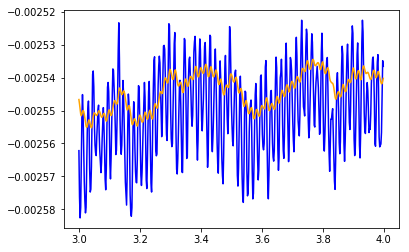

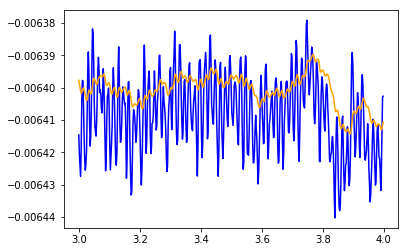

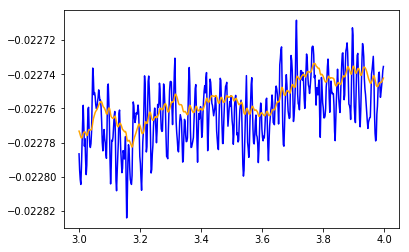

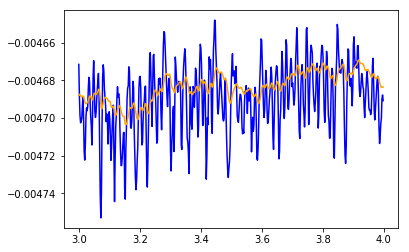

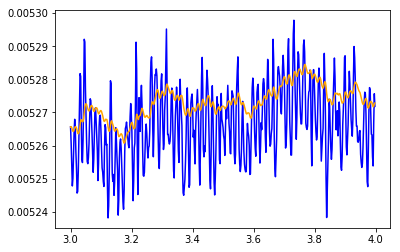

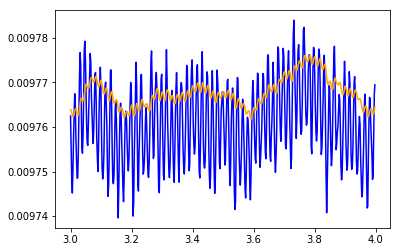

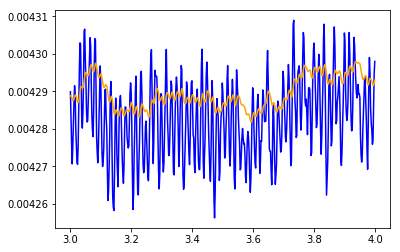

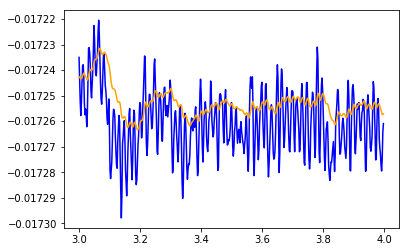

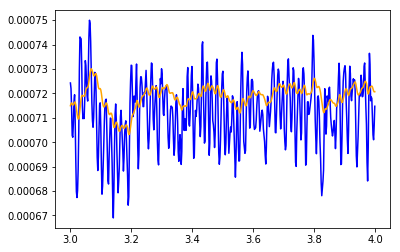

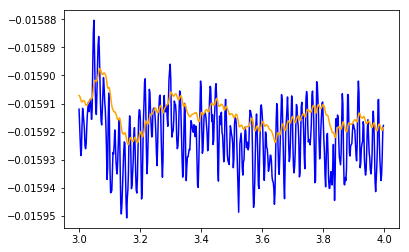

In [127]:
n_features = block_data.shape[1]
Kalm = KalmanFilter(n_features,0.5)
Kalm.train(block_data[:N_iter])
results = Kalm.fit(block_data[:N_iter])
for i in range(results.shape[1]):
    figure()
    plot(np.arange(start_index,end_index)/sfreq,block_data[start_index:end_index,i], color = 'blue') 
    plot(np.arange(start_index,end_index)/sfreq,results[start_index:end_index,i],color='orange')
show()